In [1]:
import os, re, copy, pickle
from collections import defaultdict

from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

import numpy as np
import pandas as pd
from scipy import linalg, special, stats
from sklearn.utils.extmath import stable_cumsum

from sklearn import (impute, preprocessing, model_selection, 
                     metrics, linear_model, datasets, pipeline)
import xgboost as xgb
import torch

import shap
from attributionpriors.pytorch_ops import ExpectedGradientsModel

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.path import Path
import matplotlib.patches as patches

In [2]:
# Limit to a specific GPU
RUN = 0
NRUNS = 14
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str((RUN%4))

In [3]:
REPS = 200
REFS = 100
EPOCHS = 100
ALPHAS = 121

In [4]:
X = pd.read_csv('data/nhanes/X_sparsity.csv',index_col=0)
y = np.load('data/nhanes/y_sparsity.npy')

In [5]:
OUTPATH = 'results/nhanes_mixed_200'

In [6]:
ROSSPATH = 'rebuttal/'

In [7]:
def get_data(rseed):
    Xtv, Xtest, ytv, ytest = model_selection.train_test_split(X,y,train_size=200,random_state=rseed)
    Xtrain, Xvalid, ytrain, yvalid = model_selection.train_test_split(Xtv,ytv,train_size=100,random_state=rseed)
    
    imp = impute.SimpleImputer()
    ss = preprocessing.StandardScaler()

    Xtrain_imp = imp.fit_transform(Xtrain)
    Xvalid_imp = imp.transform(Xvalid)
    Xtest_imp = imp.transform(Xtest)
    
    Xtrain_ss = ss.fit_transform(Xtrain_imp)
    Xvalid_ss = ss.transform(Xvalid_imp)
    Xtest_ss = ss.transform(Xtest_imp)
    
    return Xtrain_ss, Xvalid_ss, Xtest_ss, ytrain, yvalid, ytest
def tensorize(arr):
    ret = torch.from_numpy(arr).float().cuda()
    if len(arr.shape)==1:
        ret = ret.reshape(-1,1)
    return ret
def ngini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    g = 0.5 * rmad
    return g

## Torch

In [8]:
loss_fn = torch.nn.BCEWithLogitsLoss()
learning_rate=1e-3

## Unregularized

In [9]:
best_layers=[512,128,32]

## Load data for plotting

In [10]:
# bkps_models = models
# bkps_dropout = dropout_models
# all_dropout = []
all_models = defaultdict(list)
for i in range(NRUNS):
    # Most models
    with open(f'{OUTPATH}/{REPS}reps_{i}_all.pkl','rb') as f:
        tmodels = pickle.load(f)
    for k in tmodels:
        if k not in ('l1grad','ginigrad'): all_models[k].extend(tmodels[k])
    # Dropout models
    with open(f'{OUTPATH}/{REPS}reps_{i}_dropout.pkl','rb') as f:
        all_models['dropout'].extend(pickle.load(f))
    # Grad models
    with open(f'{OUTPATH}/{REPS}reps_{i}_grads.pkl','rb') as f:
        tmodels = pickle.load(f)
    for k in tmodels:
        all_models[k].extend(tmodels[k])
# Unreg models
with open(f'{OUTPATH}/{REPS}reps_1_unreg.pkl','rb') as f:
    tmodels = pickle.load(f)
    all_models['unreg'].append(tmodels)
models = all_models

In [11]:
print(f"Dimensions of all_models:\n(Penalties x Strengths x Reps x Fields)\n{len(all_models), len(models['ginieg']), len(models['ginieg'][0]), len(models['ginieg'][0][0])}")

Dimensions of all_models:
(Penalties x Strengths x Reps x Fields)
(16, 121, 200, 4)


In [12]:
validscores = {k: np.array([[t[0] for t in r] for r in all_models[k]]) for k in all_models}
validsparsity = {k: np.array([[ngini(t[3]) for t in r] for r in all_models[k]]) for k in all_models}

## Test Perf

### Median selected lambda values

In [16]:
getlambdas = lambda x: np.logspace(-7,5,ALPHAS) if x!='dropout' else np.linspace(0,1,ALPHAS+2)[1:-1]
with np.errstate(all='raise'):
    best_lambdas = defaultdict(list)
    for idx, i in enumerate(range(REPS)):
        for k in all_models:
            best_ind = np.argmax([all_models[k][j][idx][0] for j in range(len(all_models[k]))])
            best_lambdas[k].append(getlambdas(k)[best_ind])
    for k in best_lambdas:
        best_lambdas[k] = np.array(best_lambdas[k])
print(pd.DataFrame(data=np.array([np.median(best_lambdas[k]) for k in all_models]).reshape(-1,1),index=[k for k in all_models],columns=['Lambda']).to_latex(float_format='{:0.3e}'.format))

\begin{tabular}{lr}
\toprule
{} &    Lambda \\
\midrule
l1paramall   & 3.162e+02 \\
l2paramall   & 6.310e-01 \\
sglall       & 1.000e-03 \\
ginieg       & 1.259e+00 \\
ginimixed    & 1.259e+00 \\
l1paramfirst & 1.000e+04 \\
l2paramfirst & 1.790e+03 \\
l1eg         & 5.012e+00 \\
l2eg         & 1.000e-02 \\
dropout      & 6.598e-01 \\
l1grad       & 1.995e+00 \\
ginigrad     & 1.259e+00 \\
sglfirst     & 3.981e+00 \\
l1ross       & 1.000e+01 \\
giniross     & 1.000e+00 \\
unreg        & 1.000e-07 \\
\bottomrule
\end{tabular}



### Statistical significance results

In [22]:
ttest_results = []
for k in testscores:
    if k=='ginieg': continue
    ttest_results.append((k,
                          stats.ttest_rel(testscores['ginieg'],testscores[k]).pvalue,
                          stats.ttest_rel(testscores['ginieg'],testscores[k]).statistic,
                          stats.ttest_rel(testsparsity['ginieg'],testsparsity[k]).pvalue,
                          stats.ttest_rel(testsparsity['ginieg'],testsparsity[k]).statistic))
print(pd.DataFrame(data=np.array([t[1:] for t in ttest_results]).reshape(-1,4),index=[t[0] for t in ttest_results],columns=['ROC-AUC (p)','ROC-AUC (T)','Sparsity (p)','Sparsity (T)']).to_latex(float_format='{:0.3e}'.format))

l1paramall 2.5231926883037363e-05
l2paramall 1.2514179277929918e-28
sglall 1.3999064030184783e-07
ginimixed 0.7696981960043633
l1paramfirst 5.208985373496592e-07
l2paramfirst 6.978559383141804e-17
l1eg 7.143188505211097e-24
l2eg 1.9256751482257712e-39
dropout 5.554672628788661e-41
l1grad 1.4593259540331276e-44
ginigrad 7.793433271303234e-35
sglfirst 4.570782622314704e-14
l1ross 6.833631588355563e-46
giniross 2.518188559627326e-35
unreg 9.820746163914421e-56
\begin{tabular}{lrrrr}
\toprule
{} &  ROC-AUC (p) &  ROC-AUC (T) &  Sparsity (p) &  Sparsity (T) \\
\midrule
l1paramall   &    2.523e-05 &    4.314e+00 &     1.188e-37 &     1.602e+01 \\
l2paramall   &    1.251e-28 &    1.308e+01 &     4.477e-78 &     3.098e+01 \\
sglall       &    1.400e-07 &    5.461e+00 &     1.540e-33 &     1.468e+01 \\
ginimixed    &    7.697e-01 &   -2.932e-01 &     6.169e-01 &     5.010e-01 \\
l1paramfirst &    5.209e-07 &    5.188e+00 &     4.627e-65 &     2.567e+01 \\
l2paramfirst &    6.979e-17 &    9.148e

## Plots

In [26]:
# Lorenz plot of feature importances (lower and to right means sparser model)
def shap_cdf_plot(shaps,ax=None,**kwargs):
    if ax is None: ax = plt.gca()
    gshaps = shaps
    oshaps = np.sort(gshaps)
    df = stable_cumsum(oshaps.astype('float64'))/np.sum(oshaps).astype('float64')
    ax.plot(np.arange(oshaps.shape[0]),df,**kwargs)

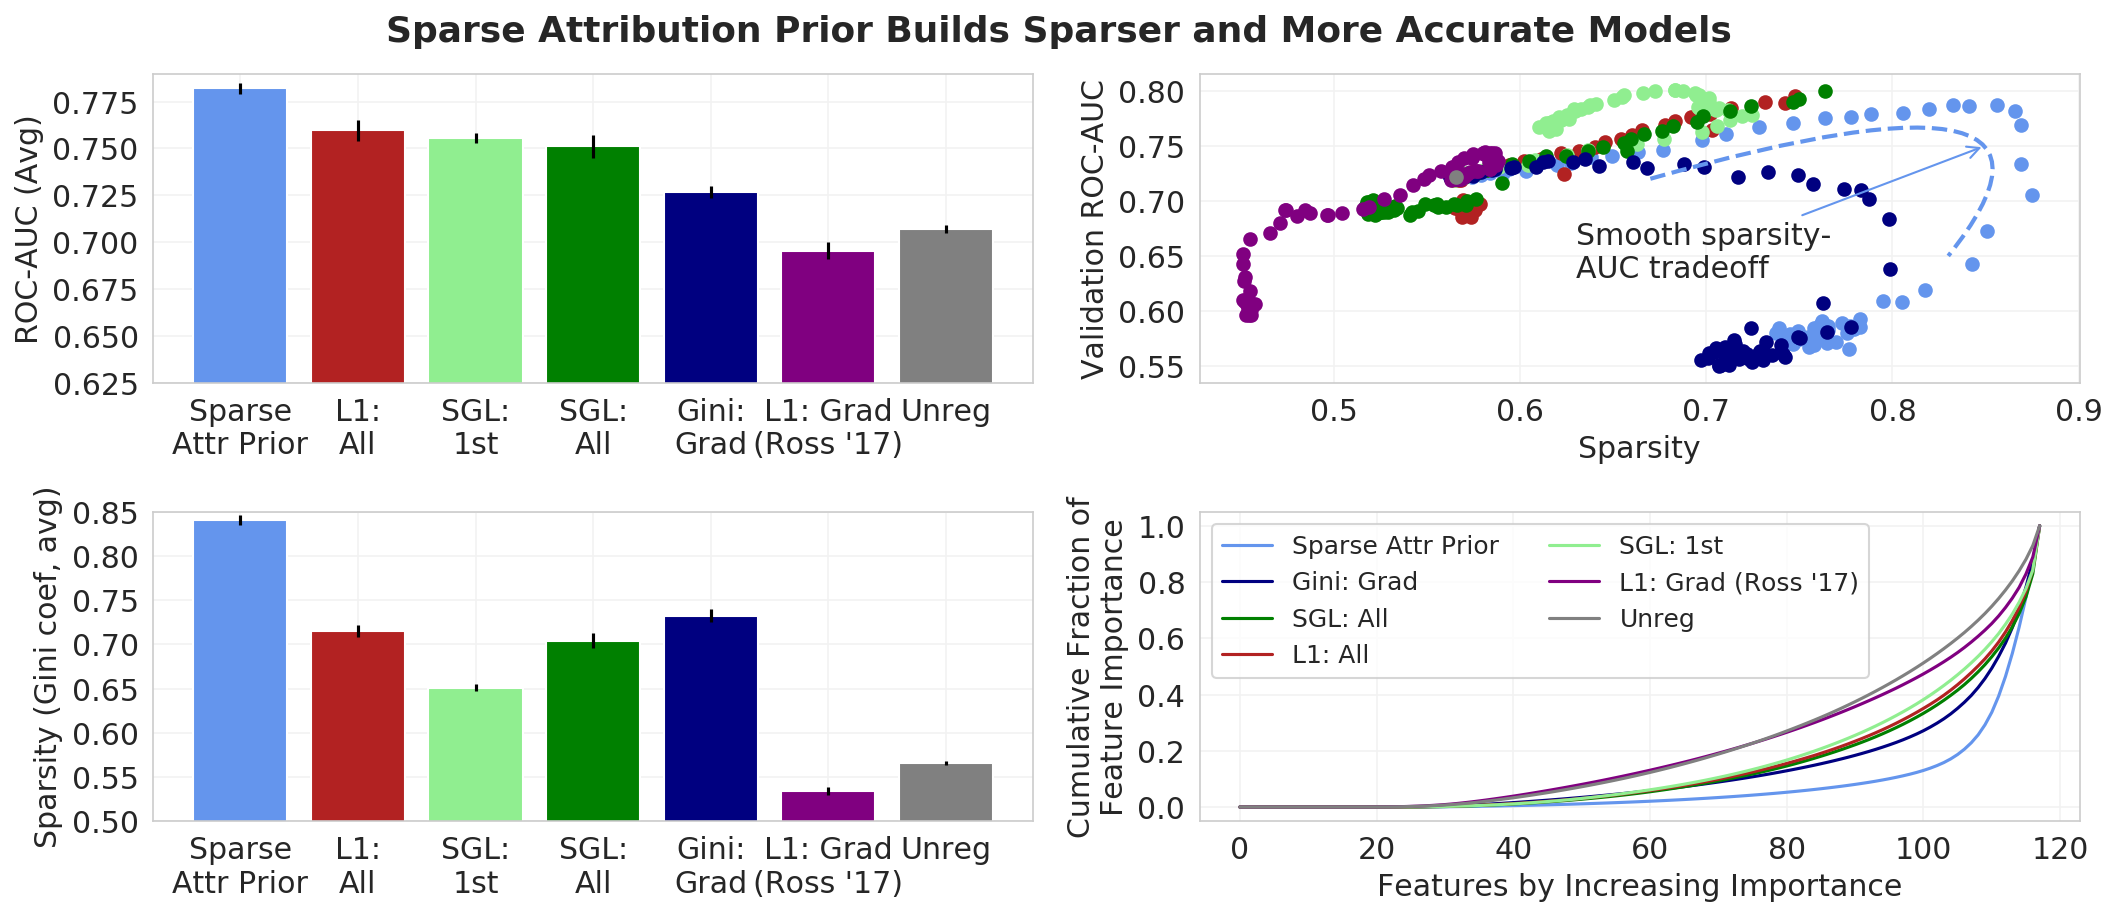

In [33]:
# Expanded names for methods
main_map = {
    'ginieg': 'Sparse\nAttr Prior',
    'ginimixed': 'Sparse\n(Mixed)',
    'ginigrad': 'Gini:\nGrad',
    'l1grad': 'L1:\nGrad',
    'l1ross': 'L1: Grad\n(Ross \'17)',
    'l1paramall': "L1:\nAll",
    'sglfirst': "SGL:\n1st",
    'sglall': 'SGL:\nAll',#"Sparse Grp\nLasso",
    'unreg': "Unreg"
}
# Map colors to methods for plotting
color_map = {
    'ginieg': 'cornflowerblue',
    'ginimixed': 'blue',
    'ginigrad': 'navy',
    'l1grad': 'lavender',
    'l1ross': 'purple',
    'l1paramall': "firebrick",
    'sglfirst': "lightgreen",
    'sglall': "green",
    'unreg': "gray"
}

# Generate plot
msort = ['ginieg','l1paramall','sglfirst','sglall','ginigrad','l1ross','unreg']

sns.set_style("whitegrid",{'grid.color':'.95'})
fig, axarr = plt.subplots(2,2,figsize=(14,6),dpi=150,constrained_layout=True)
fig.suptitle("Sparse Attribution Prior Builds Sparser and More Accurate Models",fontsize='xx-large',fontweight='bold')
from scipy.stats import sem
# plt.figure(figsize=(12,3),dpi=150)
axarr[0,0].bar(np.arange(len(msort)),
        [testscores[m].mean() for m in msort], 
        tick_label=[main_map[m] for m in msort],
       color = [color_map[m] for m in msort])
axarr[0,0].errorbar(np.arange(len(msort)),
             [testscores[m].mean() for m in msort],
             yerr=[sem(testscores[m]) for m in msort], 
             fmt='none',color='black')
axarr[0,0].set_ylim(0.625,0.79)
axarr[0,0].set_ylabel("ROC-AUC (Avg)",fontsize='x-large')
axarr[1,0].bar(np.arange(len(msort)),
        [testsparsity[m].mean() for m in msort], 
        tick_label=[main_map[m] for m in msort],
       color = [color_map[m] for m in msort])
axarr[1,0].errorbar(np.arange(len(msort)),
             [testsparsity[m].mean() for m in msort],
             yerr=[sem(testsparsity[m]) for m in msort], 
             fmt='none',color='black')
axarr[1,0].set_ylim(0.5,0.85)
axarr[1,0].set_ylabel("Sparsity (Gini coef, avg)",fontsize='x-large')

for m in ['ginieg','ginigrad','sglall','l1paramall','sglfirst','l1ross','unreg']:#msort:
    shap_cdf_plot(np.mean(np.sort(testshaps[m],axis=1),axis=0),axarr[1,1],label=main_map[m].replace('\n',' '),color=color_map[m])
axarr[1,1].legend(fontsize='large',loc='upper left',ncol=2)
axarr[1,1].set_xlabel("Features by Increasing Importance",fontsize='x-large')
axarr[1,1].set_ylabel("Cumulative Fraction of\nFeature Importance",fontsize='x-large')

for m in msort:
#     int_res = np.dstack([r.values for r in results[m]])
#     means = np.nanmean(int_res,axis=2)[:,[1,2]]
    axarr[0,1].scatter(validsparsity[m].mean(1),validscores[m].mean(1),color=color_map[m],label=main_map[m])
axarr[0,1].set_xlabel("Sparsity",fontsize='x-large')
axarr[0,1].set_ylabel("Validation ROC-AUC",fontsize='x-large')
# axarr[0,1].set_ylim(0.45)
codes = [
    Path.MOVETO,
    Path.CURVE3,
    Path.CURVE3
]
verts = [(0.67,0.72),(0.92,0.84),(0.83,0.65)]
path = Path(verts,codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='cornflowerblue', lw=2, linestyle='--')
axarr[0,1].add_patch(patch)
axarr[0,1].annotate("Smooth sparsity-\nAUC tradeoff", 
                    xy=(0.85,0.75), xytext=(0.63,0.63),fontsize='x-large',
                    arrowprops=dict(arrowstyle="->",fc='cornflowerblue',ec='cornflowerblue'))
for ax in axarr.flatten(): 
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize('x-large') 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize('x-large') 

plt.savefig('rebuttal_figures/gabe_withbars.pdf',bbox_inches='tight')
